## Сегментация изображений

План на сегодня:
1. Подготовим датасет для сегментации клеток дрожжей и микроструктур
2. Реализуем UNet для сегментации

In [1]:
from pathlib import Path

import lightning as L
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch import Tensor
from torch.utils.data import Dataset
from torchvision import transforms

### Датасет: Yeast cell in microstructures

In [2]:
# ! wget https://tudatalib.ulb.tu-darmstadt.de/bitstream/handle/tudatalib/3799/yeast_cell_in_microstructures_dataset.zip
# ! unzip yeast_cell_in_microstructures_dataset.zip -d yeast_cell_in_microstructures_dataset

Посмотрим на структуру данных:

In [3]:
! tree -P '?.pt' yeast_cell_in_microstructures_dataset/train

yeast_cell_in_microstructures_dataset/train
├── bounding_boxes
│   ├── 0.pt
│   ├── 4.pt
│   ├── 5.pt
│   └── 8.pt
├── classes
│   ├── 0.pt
│   ├── 4.pt
│   ├── 5.pt
│   └── 8.pt
├── inputs
│   ├── 0.pt
│   ├── 4.pt
│   ├── 5.pt
│   └── 8.pt
└── instances
    ├── 0.pt
    ├── 4.pt
    ├── 5.pt
    └── 8.pt

4 directories, 16 files


In [4]:
dataset_dir = Path("yeast_cell_in_microstructures_dataset")
train_dir = dataset_dir / "train"
fname = "5.pt"

for subdir in train_dir.glob("*"):
    print(f"{subdir.stem} shape: ", torch.load(subdir / fname, weights_only=True).shape)

bounding_boxes shape:  torch.Size([2, 4])
classes shape:  torch.Size([2])
instances shape:  torch.Size([2, 256, 256])
inputs shape:  torch.Size([256, 256])


Визуализируем один пример:

In [5]:
def masks_to_rgb(masks: Tensor) -> Tensor:
    """
    Преобразует тензор с бинарными масками произвольного кол-ва объектов (до 9)
    в тензор с тремя каналами, который можно конвертировать в RGB изображение

    Args:
        masks (Tensor): тензор с бинарными масками N отдельных объектов размера N x W x H
    """
    _colors = torch.tensor([
        [1.0, 0.0, 0.0],
        [0.0, 1.0, 0.0],
        [0.0, 0.0, 1.0],
        [0.5, 0.0, 0.5],
        [0.5, 0.5, 0.0],
        [0.0, 0.5, 0.5],
        [0.5, 0.3, 0.2],
        [0.2, 0.3, 0.5],
        [0.2, 0.5, 0.3],
    ])[:len(masks)]
    return (masks.unsqueeze(0) * _colors.T.unsqueeze(-1).unsqueeze(-1)).sum(dim=1)

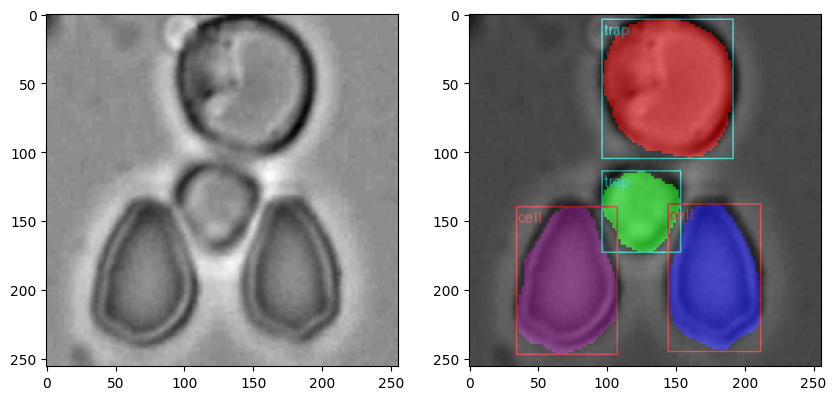

In [6]:
fname = "4.pt"
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(torch.load(train_dir / "inputs" / fname, weights_only=True), cmap="gray")
ax[1].imshow(torch.load(train_dir / "inputs" / fname, weights_only=True), cmap="gray")


colordict = {0: "red", 1: "cyan"}
class_names = {0: "cell", 1: "trap"}

classes = torch.load(train_dir / "classes" / fname, weights_only=True)

annot = torchvision.utils.draw_bounding_boxes(
    transforms.ConvertImageDtype(torch.uint8)(
        masks_to_rgb(torch.load(train_dir / "instances" / fname, weights_only=True))
    ),
    boxes=torch.load(train_dir / "bounding_boxes" / fname, weights_only=True),
    colors=[colordict[i] for i in classes.tolist()],
    labels=[class_names[i] for i in classes.tolist()],
)

ax[1].imshow(transforms.ToPILImage()(annot), alpha=0.5)

### Модуль данных

#### Реализация `Dataset`

Сначала реализуем более общий случай: датасет для instance segmentation. Из него легко будет получить датасет для semantic segmentation

In [7]:
class YeastDataset(Dataset):
    def __init__(self, subset_dir: Path) -> None:
        super().__init__()
        self.subset_dir = subset_dir
        self.items = list((self.subset_dir / "inputs").glob("*.pt"))

    def __getitem__(self, index: int) -> tuple[Tensor, dict[str, Tensor]]:
        # нужно вернуть пару
        # тензор изображения C x W x H
        # словарь с ключами boxes, masks, labels
        image_path = self.items[index]
        image = torch.load(image_path, weights_only=True).unsqueeze(
            0
        )  # (W, H) -> (1, W, H)
        classes = (
            torch.load(
                self.subset_dir / "classes" / image_path.parts[-1], weights_only=True
            )
            + 1
        )  # 0 класс - фон
        masks = torch.load(
            self.subset_dir / "instances" / image_path.parts[-1], weights_only=True
        )
        boxes = torch.load(
            self.subset_dir / "bounding_boxes" / image_path.parts[-1], weights_only=True
        )
        return image, dict(
            boxes=boxes,
            labels=classes,
            masks=masks,
        )

    def __len__(self) -> int:
        return len(self.items)

Проверим, что всё отрисовывается корректно:

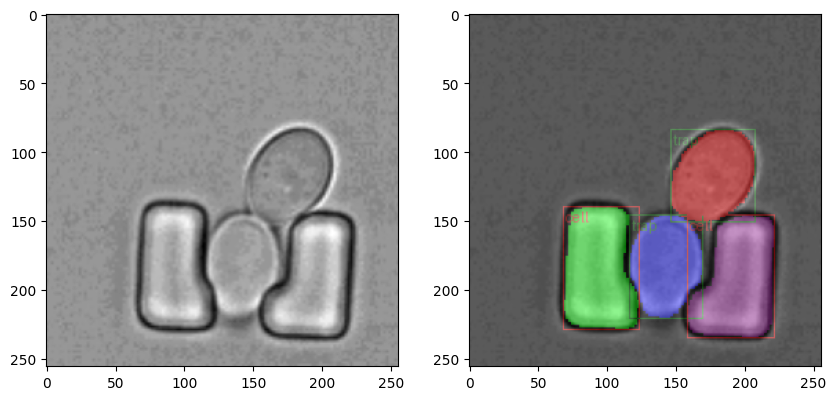

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

train_dataset = YeastDataset(train_dir)

x, target = train_dataset[5]
ax[0].imshow(x[0], cmap="gray")
ax[1].imshow(x[0], cmap="gray")


colordict = {1: "red", 2: "green"}
class_names = {1: "cell", 2: "trap"}

annot = torchvision.utils.draw_bounding_boxes(
    transforms.ConvertImageDtype(torch.uint8)(masks_to_rgb(target["masks"])),
    boxes=target["boxes"],
    colors=[colordict[i.item()] for i in target["labels"]],
    labels=[class_names[i.item()] for i in target["labels"]],
)
ax[1].imshow(transforms.ToPILImage()(annot), alpha=0.4)

А теперь отнаследуемся и сделаем правки, чтобы возвращались маски по классам:

In [9]:
class YeastSemanticSegmDataset(YeastDataset):
    def __getitem__(self, index: int) -> tuple[Tensor, Tensor]:
        image, annotation = super().__getitem__(index)
        # нужно сформировать маску: тензор размера W x H, где для каждого пиксела указан класс
        mask = (
            (annotation["masks"] * annotation["labels"].view(-1, 1, 1)).sum(dim=0)
        ).long()

        return image, mask

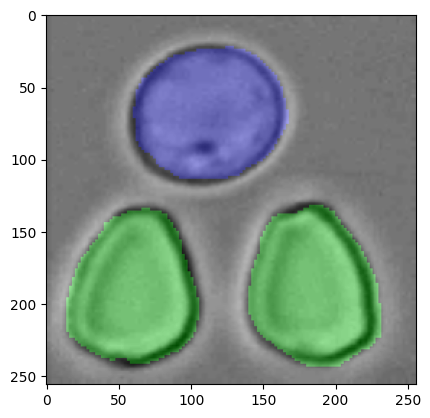

In [10]:
train_dataset = YeastSemanticSegmDataset(train_dir)

x, y = train_dataset[0]
y = torch.nn.functional.one_hot(y, 3).permute(2, 0, 1).float()
y[0] = 0.0

fig, ax = plt.subplots(1, 1)
ax.imshow(x[0], cmap="gray")
ax.imshow(transforms.ToPILImage()(y), alpha=0.3)

#### `DataModule`: универсальный для обеих задач

In [11]:
from typing import Any, Callable, Type

from lightning.pytorch.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS
from torch.utils.data import DataLoader

_collate_fn_t = Callable[[list[tuple[Tensor, Any]]], Any]


class Datamodule(L.LightningDataModule):
    def __init__(
        self,
        datadir: Path,
        dataset_class: Type[Dataset],
        batch_size: int,
        train_subdir: str = "train",
        val_subdir: str = "val",
        test_subdir: str = "test",
    ) -> None:
        super().__init__()
        self.batch_size = batch_size
        self.dataset_class = dataset_class
        self.train_dir = datadir / train_subdir
        self.val_dir = datadir / val_subdir
        self.test_dir = datadir / test_subdir

    @property
    def collate_fn(self) -> _collate_fn_t | None:
        if self.dataset_class == YeastSemanticSegmDataset:
            return None
        else:
            return lambda batch: tuple(zip(*batch))

    def setup(self, stage: str) -> None:
        if stage in ("fit", "validate"):
            self.val_dataset = self.dataset_class(self.val_dir)
        if stage == "fit":
            self.train_dataset = self.dataset_class(self.train_dir)
        elif stage == "test":
            self.test_dataset = self.dataset_class(self.test_dir)

    def train_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            collate_fn=self.collate_fn,
        )

    def val_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=self.collate_fn,
        )

    def test_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=self.collate_fn,
        )

In [12]:
torch.manual_seed(42)
datamodule = Datamodule(
    datadir=Path("yeast_cell_in_microstructures_dataset"),
    dataset_class=YeastSemanticSegmDataset,
    batch_size=8,
)
datamodule.setup("fit")
images, masks = next(iter(datamodule.train_dataloader()))
print(images.shape)
print(masks.shape)

torch.Size([8, 1, 256, 256])
torch.Size([8, 256, 256])


### Модель для семантической сегментации

Возьмём реализацию Unet из https://github.com/milesial/Pytorch-UNet

<!-- [](https://camo.githubusercontent.com/41ded1456b9dbe13b8d73d8da539dac95cb8aa721ebe5fb798af732ca9f04c92/68747470733a2f2f692e696d6775722e636f6d2f6a6544567071462e706e67?raw=true) -->

<!-- [network architecture](https://i.imgur.com/jeDVpqF.png) -->

<img src="https://i.imgur.com/jeDVpqF.png" style="background:white" width="600"/>

#### Строительные блоки UNet

Возьмём блоки из оригинального репозитория и посмотрим на их строение.

Основной материал - блок из двух свёрток и нормализаций. Такое мы уже видели

In [13]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(
        self, in_channels: int, out_channels: int, mid_channels: int | None = None
    ) -> None:
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.double_conv(x)

Далее блок для Downsampling - просто комбинация наших свёрток с MaxPool. Тоже знакомый мотив для быстрого уменьшения размерности.

In [14]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.maxpool_conv(x)

А теперь что-то новое: нам нужно из активаций малого пространственного разрешения снова восстанавливать исходное разрешение. Делать мы это также будем в несколько этапов, но теперь у нас есть несколько вариантов.

Простой - использовать интерполяцию при увеличении размерности, например билинейную.

Посложнее - вставить обратные свёртки и сделать обучаемый upsampling

<img src="../attachments/transposeconv.png" style="background:white" width="600"/>

In [15]:
from torch import nn

x = torch.tensor([[0, 1], [2, 3]], dtype=float).view(1, 2, 2)
kernel = torch.tensor([[4, 1], [2, 3]], dtype=float).view(1, 1, 2, 2)
deconv = nn.ConvTranspose2d(1, 1, kernel_size=2, bias=False)
deconv.weight.data = kernel
deconv(x)

tensor([[[ 0.,  4.,  1.],
         [ 8., 16.,  6.],
         [ 4., 12.,  9.]]], dtype=torch.float64, grad_fn=<SqueezeBackward1>)

В итоге блок выглядит так:

In [16]:
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(
        self, in_channels: int, out_channels: int, bilinear: bool = True
    ) -> None:
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x_prev: Tensor, x_skip: Tensor) -> Tensor:
        x_prev = self.up(x_prev)
        # input is BCHW
        d_height = x_skip.size()[2] - x_prev.size()[2]
        d_width = x_skip.size()[3] - x_prev.size()[3]

        x_prev = F.pad(
            x_prev,
            [
                d_width // 2,
                d_width - d_width // 2,
                d_height // 2,
                d_height - d_height // 2,
            ],
        )
        x = torch.cat([x_skip, x_prev], dim=1)
        return self.conv(x)

#### Архитектура модели

Реализация из репозитория:

In [17]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [18]:
model = UNet(n_channels=1, n_classes=3, bilinear=False)
sum([p.numel() for p in model.parameters()])

31036611

В такой реализации нет возможности создавать сеть произвольного размера. Давайте перепишем в таком виде:

In [19]:
class UNet(nn.Module):
    def __init__(
        self,
        n_channels: int,
        n_classes: int,
        channel_sizes: list[int],
        bilinear: bool = False,
    ):
        super().__init__()
        self.in_conv = DoubleConv(in_channels=n_channels, out_channels=channel_sizes[0])
        self.downscaler = self.create_downscaler(channel_sizes, bilinear)
        self.upscaler = self.create_upscaler(channel_sizes[::-1], bilinear)
        self.head = nn.Conv2d(channel_sizes[0], n_classes, kernel_size=1)

    @classmethod
    def create_downscaler(
        cls, channel_sizes: list[int], bilinear: bool = False
    ) -> nn.ModuleList:
        """
        Создаём список модулей на основе размеров каналов.
        если используется билинейная интерполяция вместо обратной свёртки,
        то размер последнего (самого большого) канала делаем вдвое меньше

        Args:
            channel_sizes (list[int]): список размеров каналов, напр. [16, 32, 64]
            bilinear (bool, optional): если True, в модели используется билинейная интерполяция
                для выравнивания размеров активаций.
        """
        factor = 2 if bilinear else 1
        down_factors = [1] * (len(channel_sizes) - 2) + [factor]
        return nn.ModuleList(
            [
                Down(fin, fout // dfactor)
                for fin, fout, dfactor in zip(
                    channel_sizes[:-1], channel_sizes[1:], down_factors
                )
            ]
        )

    @classmethod
    def create_upscaler(
        cls, channel_sizes: list[int], bilinear: bool = False
    ) -> nn.ModuleList:
        """
        Создаём список модулей на основе размеров каналов.
        Если используется билинейная интерполяция вместо обратной свёртки,
        то размер первого (самого большого) канала делаем вдвое меньше

        Args:
            channel_sizes (list[int]): список размеров каналов, напр. [16, 32, 64]
            bilinear (bool, optional): если True, в модели используется билинейная интерполяция
                для выравнивания размеров активаций.
        """
        factor = 2 if bilinear else 1
        up_factors = [factor] * (len(channel_sizes) - 2) + [1]
        return nn.ModuleList(
            [
                Up(fin, fout // ufactor, bilinear=bilinear)
                for fin, fout, ufactor in list(
                    zip(channel_sizes[:-1], channel_sizes[1:], up_factors)
                )
            ]
        )

    def forward(self, x: Tensor) -> Tensor:
        # создаём список для хранения промежуточных активаций
        xs = []
        # делаем входную свёртку
        x = self.in_conv(x)

        # downscaling
        for conv in self.downscaler:
            xs.append(x)
            x = conv(x)

        # разворачиваем промежуточные активации и делаем upscaling
        xs.reverse()
        for conv, act in zip(self.upscaler, xs):
            x = conv(x, act)

        # финальная свёртка для получения логитов пикселей
        logits = self.head(x)
        return logits

In [20]:
torch.manual_seed(42)
model = UNet(n_channels=1, n_classes=3, channel_sizes=[16, 32, 64, 128], bilinear=True)
sum([p.numel() for p in model.parameters()])

268515

Проверим, что модель способна выучить один батч данных:

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [22]:
n_steps = 50
for i in range(n_steps):
    predictions = model.forward(images)
    loss = F.cross_entropy(predictions, masks)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if (i + 1) % 5 == 0:
        print(loss)

tensor(0.6385, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.4175, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.2936, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.2168, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.1690, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.1373, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.1155, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.0939, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.0841, device='mps:0', grad_fn=<NllLoss2DBackward0>)
tensor(0.0723, device='mps:0', grad_fn=<NllLoss2DBackward0>)


Визуализируем предсказания:

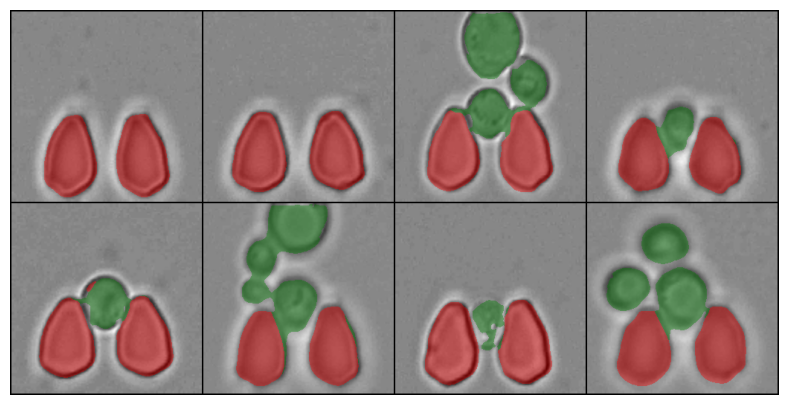

In [23]:
original_images_grid = torchvision.utils.make_grid(images, nrow=4, normalize=True)
masks_grid = torchvision.utils.make_grid(
    torch.nn.functional.one_hot(predictions.argmax(dim=1), 3).permute(0, 3, 1, 2)[:, 1:]
    > 0,
    nrow=4,
)

predictions_grid = torchvision.utils.draw_segmentation_masks(
    original_images_grid,
    masks=masks_grid,
    alpha=0.4,
    colors=["red", "green"],
)

plt.figure(figsize=(12, 5))
plt.axis("off")
plt.imshow(transforms.ToPILImage()(predictions_grid))

### Упражнения

1. Определитесь с набором метрик, которые подойдут для оценки точности модели
2. Обучите модель на полном датасете, сохраняя метрики и примеры предсказаний раз в 5 эпох. Можете использовать Lightning.